# Automated Smile Detection Part 2: Preprocess & Modeling
This second notebook will walk through data preparation and initial modeling. The original dataset was downloaded from this [repo](https://github.com/hromi/SMILEsmileD). It consists of 3,690 images of smiling faces and 9,476 images of non-smiling faces.  

# Imports

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%load_ext blackcellmagic

# EDA  
Read in some sample images from smiles and non-smiles.

In [2]:
pos_imgs = os.listdir("../data/train/positive")
pos_imgs = [os.path.join("../data/train/positive", img) for img in pos_imgs]
pos_subset = pos_imgs[0:9]
pos_subset[0]

'../data/train/positive/63.jpg'

In [3]:
neg_imgs = os.listdir("../data/train/negative")
neg_imgs = [os.path.join("../data/train/negative", img) for img in neg_imgs]
neg_subset = neg_imgs[0:9]
neg_subset[0]

'../data/train/negative/9733.jpg'

## Process Images with OpenCV

In [4]:
def process_imgs(imgs: list) -> list:
    processed_imgs = [cv2.imread(img) for img in imgs]
    return processed_imgs

### Positive Samples  
Below is a 3x3 grid of sample images from the positive training set.

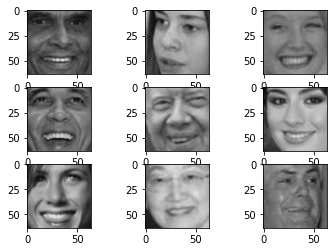

In [5]:
pos_subset_processed = process_imgs(pos_subset)

fig, axs = plt.subplots(nrows=3, ncols=3)
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(pos_subset_processed[i])
    
plt.show()

### Negative Samples  
Below is a 3x3 grid of sample images from the negative training set.

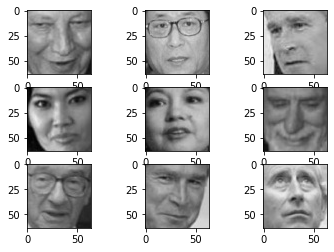

In [6]:
neg_subset_processed = process_imgs(neg_subset)

fig, axs = plt.subplots(nrows=3, ncols=3)
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(neg_subset_processed[i])
    
plt.show()

### Image Shape  
All of the images are grey-scale and consist of the following shape:

In [7]:
pos_subset_processed[0].shape

(64, 64, 3)

Based on the shape of the images, I won't have to perform any size reduction during model preprocessing.

# Modeling  
The first modeling attempt will be made with the keras module embedded in tensforflow. Depending on model performance, AutoML tools may be tested (i.e. GCP AutoML Vision & AWS Sagemaker)

In [8]:
train_dir = "../data/train"
test_dir = "../data/test"
val_dir = "../data/validation"

## Training & Validation Generators

In [9]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, target_size=(150, 150), class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir, batch_size=20, target_size=(150, 150), class_mode="binary"
)

Found 5380 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Build Model 1  
The first model is a very straightforward CNN with 4 convolutional layers, max pooling and two fully connected layers.

In [15]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
    model.add(layers.MaxPool2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Reshape((6272,)))
    #model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=["acc"],
    )
    return model

In [16]:
model = build_model()

### Model Summary

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

### Train Model

In [18]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=val_generator,
    validation_steps=50,
)

Epoch 1/30
100/100 [==============================] - 65s 648ms/step - loss: 0.6564 - acc: 0.6165 - val_loss: 0.5267 - val_acc: 0.8410
Epoch 2/30
100/100 [==============================] - 64s 644ms/step - loss: 0.4169 - acc: 0.8285 - val_loss: 0.3593 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 67s 673ms/step - loss: 0.3538 - acc: 0.8415 - val_loss: 0.3492 - val_acc: 0.8510
Epoch 4/30
100/100 [==============================] - 64s 643ms/step - loss: 0.3227 - acc: 0.8650 - val_loss: 0.3959 - val_acc: 0.8370
Epoch 5/30
100/100 [==============================] - 64s 641ms/step - loss: 0.3322 - acc: 0.8675 - val_loss: 0.3200 - val_acc: 0.8700
Epoch 6/30
100/100 [==============================] - 64s 641ms/step - loss: 0.3343 - acc: 0.8670 - val_loss: 0.3073 - val_acc: 0.8790
Epoch 7/30
100/100 [==============================] - 64s 641ms/step - loss: 0.2815 - acc: 0.8855 - val_loss: 0.3050 - val_acc: 0.8750
Epoch 8/30
100/100 [==============================] - 6

In [19]:
model.save("../models/smile_model_01_v2.h5")

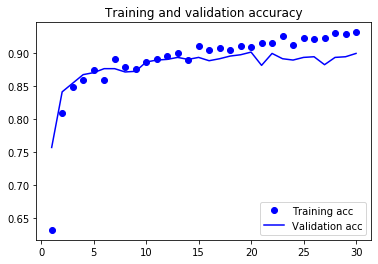

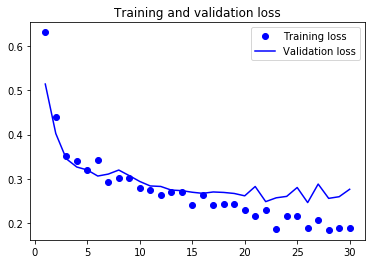

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Build Model 2  
Model two institutes the same architecture as the first mode, but it implements dropout and data augmentation.  

### Data Augmentation

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Validation generator doesn't need augmentation
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, target_size=(150, 150), class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir, batch_size=20, target_size=(150, 150), class_mode="binary"
)

Found 5380 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Model with Dropout

In [19]:
def model_dropout():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=["acc"],
    )
    return model

In [20]:
model_dropout = model_dropout()

In [21]:
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [22]:
history_drp = model_dropout.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=val_generator,
    validation_steps=50,
)

Epoch 1/50
100/100 [==============================] - 61s 613ms/step - loss: 0.6938 - acc: 0.5055 - val_loss: 0.6873 - val_acc: 0.5140
Epoch 2/50
100/100 [==============================] - 73s 725ms/step - loss: 0.6903 - acc: 0.5335 - val_loss: 0.6808 - val_acc: 0.5260
Epoch 3/50
100/100 [==============================] - 66s 660ms/step - loss: 0.6832 - acc: 0.5560 - val_loss: 0.6344 - val_acc: 0.7280
Epoch 4/50
100/100 [==============================] - 64s 639ms/step - loss: 0.6628 - acc: 0.6015 - val_loss: 0.5906 - val_acc: 0.6860
Epoch 5/50
100/100 [==============================] - 63s 626ms/step - loss: 0.6448 - acc: 0.6195 - val_loss: 0.5848 - val_acc: 0.7820
Epoch 6/50
100/100 [==============================] - 61s 614ms/step - loss: 0.6402 - acc: 0.6560 - val_loss: 0.5377 - val_acc: 0.7860
Epoch 7/50
100/100 [==============================] - 64s 635ms/step - loss: 0.6198 - acc: 0.6510 - val_loss: 0.5062 - val_acc: 0.7640
Epoch 8/50
100/100 [==============================] - 6

In [23]:
model_dropout.save("smile_model_02.h5")

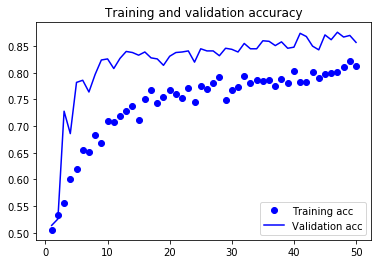

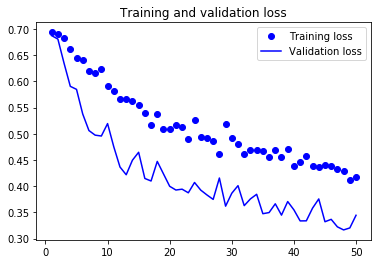

In [24]:
acc = history_drp.history['acc']
val_acc = history_drp.history['val_acc']
loss = history_drp.history['loss']
val_loss = history_drp.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()